In [1]:
'''
This notebook will output a dataset .npy of Lagrangian particle flow map
Total particle number : Nx x Ny
Finite Time interval : t0 --> t0 + T (trajectory data during this T will not be saved)
Output variable : 2D numpy array of tuples;
                  Each tuple (x0, y0, x1, y1) stores initial and final positions of a Lagrangian particle,
                  i.e. r(t0) = (x0, y0) and r(t0+T) = (x1, y1)
''' 


import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi

from scipy import integrate
import scipy as sp

In [19]:
### create flow domain 
# there are same number of Lagrangian and Eulerian grid points (Nx, Ny)
Lx, Ly = (2, 1)
Nx, Ny = (141, 71)
x = np.linspace(0,Lx,Nx)
y = np.linspace(0,Ly,Ny)
X, Y = np.meshgrid(x,y)
dx = Lx/(Nx-1)
dy = dx

t0 = 0
tf = 0.3

In [20]:
### compute a double gyro flow field

# flow parameters
A = 0.1
eps = 0.25
omega = pi

# flow streamline
a = lambda t: eps * np.sin(omega * t)
b = lambda t: 1 - 2 * a(t)
fxt = lambda x, t: a(t) * (x**2) + b(t) * x
psi = lambda x,y,t: A * np.sin(np.pi*fxt(x,t)) * np.sin(np.pi*y)

# flow velocity field (need to sort out the signs!!)
U = lambda x,y,t: -A*np.pi * np.sin(np.pi*fxt(x,t)) * np.cos(np.pi*y)
V = lambda x,y,t: A*np.pi * np.cos(np.pi*fxt(x,t)) * np.sin(np.pi*y) * (2*a(t)*x + b(t))

# # visualise flow field at t0
# t0 = 0
# fig, ax = plt.subplots(layout='constrained')
# CS = ax.contourf(X, Y, V(X,Y,3), 50)
# ax.set_aspect('equal')
# fig.colorbar(CS)

In [23]:
#### compute particle trajectories

# inertial particle parameters in the MR equation
St = 1
R = 0
W = 5


# Solve the IVP RK4 -- for inertial particles
def solve_ivp_active(Lag_point, t0 = t0, tf = tf):
  '''
  Assuming that the inertial particles follow flow field before integrating path, i.e. only released at t0
  '''
  
  # define the IVP to solve -- for INERTIAL particles

  t_span = np.linspace(t0,tf,500)

  def active_tracer_traj(t, Z) :
    # state-space vector Z[2] is vx, Z[3] is vy
      # compute flow field at particle position (xp, yp)
      xp = Z[0]
      yp = Z[1]
      a = eps * np.sin(omega * t)
      b = 1 - 2 * eps * np.sin(omega * t)
      fxt = a*(xp**2) + b*xp
      dfdt = (xp**2) * eps * omega * np.cos(omega * t) -2* xp *  eps * omega * np.cos(omega * t)
      dfdx = 2*a*xp + b
      Uf = -A*np.pi * np.sin(np.pi*fxt) * np.cos(np.pi*yp)
      Vf = A*np.pi * np.cos(np.pi*fxt) * np.sin(np.pi*yp) * dfdx
      dUdt = -A*(np.pi**2) * np.cos(np.pi*fxt) * np.cos(np.pi*yp) * dfdt
      dVdt = A*np.pi * np.sin(np.pi*yp) * ( -np.pi*np.sin(np.pi*fxt)*dfdt*dfdx + np.cos(np.pi*fxt) * (2*xp*eps*omega*np.cos(omega * t) - 2*eps*omega*np.cos(omega * t)) )
      dUdx = -A*(np.pi**2) * np.cos(np.pi*fxt) * np.cos(np.pi*yp) * dfdx
      dUdy = A*(np.pi**2) * np.sin(np.pi*fxt) * np.sin(np.pi*yp)
      dVdx = A*np.pi * np.sin(np.pi*yp) * ( -np.pi*np.sin(np.pi*fxt)*(dfdx**2) + np.cos(np.pi*fxt) * (2*a) )
      dVdy = A*(np.pi**2) * np.cos(np.pi*fxt) * np.cos(np.pi*yp) * dfdx



      # define derivatives
      dxpdt = Z[2]  # vx
      dypdt = Z[3]  # vy
      ddxpdtt = (Uf - dxpdt)/St + (3*R/2) * (dUdt + Uf*dUdx + Vf*dUdy)
      ddypdtt = (Vf - dypdt)/St + (3*R/2) * (dVdt + Uf*dVdx + Vf*dVdy) - W
      return [dxpdt, dypdt, ddxpdtt, ddypdtt]


  x0, y0 = Lag_point
  sol = sp.integrate.solve_ivp(active_tracer_traj, [t0, tf], [x0, y0, U(x0,y0,t=t0), V(x0,y0,t=t0)], t_eval=t_span, vectorized=True)
  xpt, ypt = sol.y[0], sol.y[1]
  return xpt, ypt

  
  

In [ ]:
# t = 3
# import sympy as sp

# # Define symbols
# x, y, t, A, eps, omega = sp.symbols('x y t A eps omega')

# # Define a(t) and b(t)
# a_t = eps * sp.sin(omega * t)
# b_t = 1 - 2 * eps * sp.sin(omega * t)

# # Define f(x, t)
# f_x_t = a_t * x**2 + b_t * x

# # Define psi(x, y, t)
# psi_sym = A * sp.sin(sp.pi * f_x_t) * sp.sin(sp.pi * y)

# # flow velocity field Uf(x,y,t) and Vf(x,y,t)
# Uf_sym = -sp.diff(psi_sym, y)
# Vf_sym = sp.diff(psi_sym, x)

# psi = psi_sym.subs({A: A, eps: eps, omega: omega, x: sp.Matrix(X), y:sp.Matrix(Y), t: 3})


In [24]:
### compute the INTERTIAL particle flow map in the whole domain

# create a flattened array of grid points, first index is x
grid_coords = np.column_stack((X.ravel(), Y.ravel()))
final_coords = np.empty_like(grid_coords, dtype=object)


# ## the slow version
# for i, point in enumerate(grid_coords):
#     x0, y0 = grid_coords[i, 0], grid_coords[i, 1]
#     rt = solve_ivp_active((x0, y0), 0, 15)
#     final_coords[i,:] = rt[0][-1], rt[1][-1]


## using multiprocessing
'''
output [res], a list with len = Nx*Ny, 
each list element is an array of t_span for one particle
'''
from multiprocessing import Pool

n_proc = 12
with Pool(n_proc) as pool:
    args = list( grid_coords )
    res = pool.map( solve_ivp_active, args )

final_coords = np.array([(point[0][-1], point[1][-1]) for point in res], dtype=float)



## construct flow map of positions at t0 and tf
flow_map = np.column_stack((grid_coords, final_coords))
# np.save('inertial_flow_map.npy', flow_map)


In [25]:
np.save(f'inertialGravW{W}_flow_map_w{omega/np.pi}_{tf}_St{St}_R{R}.npy', flow_map)

In [ ]:

# grid_coords = np.column_stack((X.ravel(), Y.ravel()))
# final_coords = np.empty_like(grid_coords, dtype=object)
# from multiprocessing import Pool
# with Pool( 12 ) as pool:
#     args = list( grid_coords )
#     res = pool.map( solve_ivp_active, args )
# res = np.array( res )


In [ ]:
# res.shape
# # final_coords = res[:,:,-1]
# final_coords = res.copy()
# flow_map = np.column_stack((grid_coords, final_coords))

In [ ]:

# flow_map = np.column_stack((grid_coords, final_coords))
# final_coords[i,:] = rt[0][-1], rt[1][-1]


In [26]:
# this is a 3D array and the first two indicies are the particle "Name" (defined by its initial position)
flow_map_arr = np.array([tuple(row) for row in flow_map]).reshape((Ny, Nx, 4))
X0 = flow_map_arr[:,:,0]
Y0 = flow_map_arr[:,:,1]
Xf = flow_map_arr[:,:,2]
Yf = flow_map_arr[:,:,3]

In [27]:
def compute_ftle(xi, yj, t0, tf):

    """
    the arguments xi, yj are indices, not coordinates
    """

    D = np.zeros((2,2))   # 2D deformation gradient matrix
    D[0,0] = (Xf[yj, xi+1] - Xf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[0,1] = (Xf[yj+1, xi] - Xf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])
    D[1,0] = (Yf[yj, xi+1] - Yf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
    D[1,1] = (Yf[yj+1, xi] - Yf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])

    CGDtensor = D.T @ D # symmetric square real matrix must have orthogonal eigenvectors,  the SV's are the absolute values of the eigenvalues
    # _, SV, _ = np.linalg.svd(CGDtensor, hermitian=True)

    _, SV, _ = np.linalg.svd(D)

    if SV[0] < 1:
        SV = np.ones_like(SV)
    else:
        SV[1] = 1/SV[0]

    ftle = np.log(SV[0]) / np.abs(tf-t0) # use the largest singular value of D
    
    return ftle

In [9]:
# D = np.zeros((2,2))   # 2D deformation gradient matrix
# D[0,0] = (Xf[yj, xi+1] - Xf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
# D[0,1] = (Xf[yj+1, xi] - Xf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])
# D[1,0] = (Yf[yj, xi+1] - Yf[yj, xi-1]) / (X0[yj, xi+1] - X0[yj, xi-1])
# D[1,1] = (Yf[yj+1, xi] - Yf[yj-1, xi]) / (Y0[yj+1, xi] - Y0[yj-1, xi])

# CGDtensor = D.T @ D # symmetric square real matrix must have orthogonal eigenvectors,  the SV's are the absolute values of the eigenvalues
# _, SV, _ = np.linalg.svd(CGDtensor, hermitian=True)

# # ftle = np.log(SV[0]) / np.abs(tf-t0)
# CGDtensor

In [ ]:
# incompressibility = True
# np.linalg.det(CGDtensor)
# eigenvalues, _ = np.linalg.eig(CGDtensor)
# # if incompressibility:

# np.linalg.det(CGDtensor)

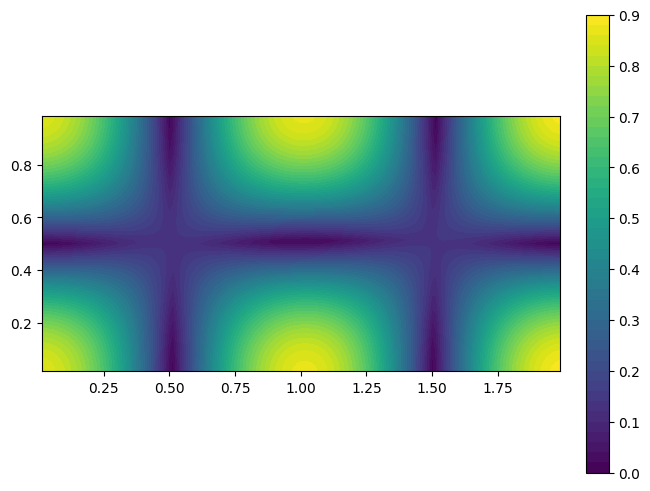

In [28]:
FTLE_field = np.empty((Ny-2, Nx-2))
# FTLE_field = np.empty((Ny, Nx))


for xi in range(Nx-2) :
    for yj in range(Ny-2) :
        FTLE_field[yj, xi] = compute_ftle((xi+1), (yj+1), t0, tf)

# for xi in range(1, Nx-1) :
#     for yj in range(1, Ny-1) :
#         FTLE_field[yj, xi] = compute_ftle(xi, yj, t0, tf)



fig, ax = plt.subplots(layout='constrained')
CS = ax.contourf(X[1:-1, 1:-1], Y[1:-1, 1:-1], FTLE_field, 50)
ax.set_aspect('equal')
cbar = fig.colorbar(CS)